# 소아 당뇨 환자를 위한 혈당 예측 모델링
당뇨 환자의 혈당 반응 데이터를 바탕으로, 식후 혈당 변화(1시간/2시간)를 예측하는 XGBoost 회귀 모델 구축 예시입니다.


In [27]:
import pandas as pd
import numpy as np
from datetime import timedelta
# from datetime import datetime
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

## 1. 데이터 불러오기

In [28]:
df = pd.read_csv('CGM_YoungChildren.csv')
print('데이터 shape:', df.shape)

데이터 shape: (117130, 8)


## 2. 컬럼별 상세 설명

- **ID**: 참가자 고유번호
- **Timestamp**: 측정 시각 (YYYY-MM-DD hh:mm:ss)
- **Age**: 참가자 나이
- **Gender**: 참가자 성별 (M: 남성, F: 여성)
- **GL**: 측정 혈당
- **Weight(kg)**: 체중(kg)
- **Height(cm)**: 키(cm)
- **Time of Day**: 식사 시간대 (ex. 아침, 점심, 저녁, 야식), 식사 시각의 컨텍스트 정보로, 혈당 반응에 영향을 줄 수 있음


In [29]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce') # 'Timestamp' 컬럼을 datetime 타입으로 변환. 변환 실패 시 NaT로 처리
print('컬럼:', df.columns.tolist())

컬럼: ['ID', 'Timestamp', 'GL', 'Weight(kg)', 'Height(cm)', 'Age', 'Gender', 'Time of Day']


## 3. 식사 이벤트 예측 계산

In [30]:
result_rows = []

rise_check_window_min = 20         # 식사 후 혈당상승을 확인할 시간(분)
rise_check_window = rise_check_window_min // 5  # 데이터 간격이 5분 단위라고 가정(20/5=4개)
pre_window_min = 30                # 식전 혈당평균 구간(분)
rise_thresh = 15                   # 혈당상승폭 기준 (mg/dL)
min_gap = timedelta(minutes=90)    # 이벤트 간 최소 간격

# 사용자별 데이터 처리
for user_id, user_df in df.groupby('ID'):
    user_df = user_df.sort_values('Timestamp').reset_index(drop=True)
    meal_events = []
    last_event_time = None

    # 식사 이벤트 예상
    for i in range(rise_check_window, len(user_df)):
        # 1) 식전 30분 평균 계산
        pre_start = max(i - (pre_window_min // 5), 0)
        pre_gl = user_df['GL'].iloc[pre_start:i].mean()

        # 2) 식후 20분 내 최대 혈당 찾기
        post_end = min(i + rise_check_window, len(user_df)-1)
        post_max = user_df['GL'].iloc[i:post_end+1].max()

        # 3) 상승폭 계산
        rise = post_max - pre_gl
        cur_time = user_df['Timestamp'].iloc[i]

        # 4) 혈당이 기준 이상 오르고, 이벤트 간 최소 간격을 넘겼다면 식사 이벤트로 추정
        if rise >= rise_thresh:
            if (last_event_time is None) or ((cur_time - last_event_time) >= min_gap):
                meal_events.append(cur_time)
                last_event_time = cur_time

    # 추정된 식사 이벤트별로 상세 정보 추출 (1시간 예측에 필요한 부분만)
    for meal_time in meal_events:
        # 5) 식전 30분 평균 (추정 이벤트 시각 기준)
        pre_mask = (user_df['Timestamp'] < meal_time) & \
                   (user_df['Timestamp'] >= meal_time - timedelta(minutes=pre_window_min))
        pre_gl = user_df.loc[pre_mask, 'GL'].mean()

        post_1h_start = meal_time + timedelta(minutes=40)
        post_1h_end = meal_time + timedelta(minutes=80)
        mask_1h = (user_df['Timestamp'] >= post_1h_start) & (user_df['Timestamp'] <= post_1h_end)
        
        if not user_df.loc[mask_1h].empty:
            post_1h_gl = user_df.loc[mask_1h, 'GL'].max()
        else:
            # 40~80분 구간에 값이 없다면, ±30분 내 가장 가까운 혈당값 사용
            target = meal_time + timedelta(minutes=60)
            window = 30  # ±30분
            mask_any = (user_df['Timestamp'] >= target - timedelta(minutes=window)) & \
                   (user_df['Timestamp'] <= target + timedelta(minutes=window))
            if not user_df.loc[mask_any].empty:
                idx = (user_df.loc[mask_any, 'Timestamp'] - target).abs().idxmin()
                post_1h_gl = user_df.loc[idx, 'GL']
            else:
                post_1h_gl = np.nan
                
        # 7) 변화량 계산 (1시간 후만)
        delta_gl_1h = post_1h_gl - pre_gl if pd.notnull(pre_gl) and pd.notnull(post_1h_gl) else np.nan

        # 8) 결과 row 저장 (기본정보 + 1시간 파생변수)
        meal_idx = (user_df['Timestamp'] - meal_time).abs().idxmin()
        row = user_df.loc[meal_idx].to_dict()

        row['Meal_Event_Time'] = meal_time
        row['Pre GL'] = pre_gl
        row['Post1h GL'] = post_1h_gl
        row['Delta GL 1h'] = delta_gl_1h

        result_rows.append(row)

# 결과 DataFrame 생성
df_event = pd.DataFrame(result_rows)

In [31]:
print(df_event[['ID', 'Timestamp', 'Pre GL', 'Post1h GL', 'Delta GL 1h']].head())

   ID           Timestamp      Pre GL  Post1h GL  Delta GL 1h
0   1 2000-01-01 13:15:00  132.333333      161.0    28.666667
1   1 2000-01-01 15:00:00  126.166667      146.0    19.833333
2   1 2000-01-01 20:10:00  126.666667      190.0    63.333333
3   1 2000-01-01 21:40:00  166.666667      194.0    27.333333
4   1 2000-01-01 23:25:00  112.000000      142.0    30.000000


## 4. 혈당 곡선 아래 면적(AUC) 및 보정값 계산

각 식사 이벤트마다  
- 식후 1시간, 2시간 동안의 AUC(혈당면적)  
- 식전 혈당값으로 보정된 AUC  

In [32]:
def calc_auc(trace, time_col, glucose_col):
    # 혈당 시간-농도 곡선(AUC) 계산 함수
    if trace.empty or trace.shape[0] < 2:   # 데이터가 비어있거나 2개 미만이면 NaN 반환
        return np.nan
    time_min = (trace[time_col] - trace[time_col].min()).dt.total_seconds() / 60
    glucose = trace[glucose_col].values
    auc = np.trapz(glucose, time_min)   # numpy로 면적 계산 (trapezoidal rule)
    return auc

In [33]:
aucs_1h = []

for idx, row in df_event.iterrows():
    user_id = row['ID']
    meal_time = row['Timestamp']
    user_df = df[df['ID'] == user_id]   # 해당 사용자의 전체 기록 불러오기

    # # 1시간 구간 AUC 계산
    start_1h = meal_time
    end_1h = meal_time + timedelta(minutes=60)
    mask_1h = (user_df['Timestamp'] >= start_1h) & (user_df['Timestamp'] <= end_1h) # 식사 후 1시간까지 데이터
    trace_1h = user_df.loc[mask_1h, ['Timestamp', 'GL']].copy() 
    auc_1h = calc_auc(trace_1h, 'Timestamp', 'GL')  # AUC 계산
    aucs_1h.append(auc_1h)

# AUC 값 데이터프레임에 저장
df_event['AUC_1h'] = aucs_1h

# AUC 보정(공복혈당 x 시간) 값
interval_minutes_1h = 60
df_event['AUC_adj_1h'] = df_event['AUC_1h'] - (df_event['Pre GL'] * interval_minutes_1h)


In [34]:
gender_map = {'F': 0, 'M': 1}   # 성별 변환: 여성 0, 남성 1로 매핑
df_event['Gender'] = df_event['Gender'].map(gender_map) # 성별 컬럼 숫자형으로 변환

## 5. 전처리 후 데이터 개수(샘플 수) 확인

결측치 처리 후, 학습에 실제로 사용될 행의 개수를 출력


In [35]:
# 1시간 예측에 사용할 피처와 타겟 추출
feature_cols_1h = [
    'Time of Day', 'Age', 'Gender', 'Weight(kg)', 'Height(cm)',
     'GL', 'AUC_adj_1h',
]
mask_1h = df_event['Delta GL 1h'].notna()
x_1h = df_event.loc[mask_1h, feature_cols_1h]   # 입력 데이터
y_1h = df_event.loc[mask_1h, 'Delta GL 1h']     # 타겟 데이터

# 예측에 사용될 데이터
print('1시간 row:', x_1h.shape[0])


1시간 row: 2766


## 6. 학습/테스트 데이터 분리

- 식후 1시간 혈당 변화(Delta GL 1h) 예측용 데이터셋
- 식후 2시간 혈당 변화(Delta GL 2h) 예측용 데이터셋  
**각각 별도로** 학습/테스트 세트로 분리


In [36]:
# 결측치 제거 후 학습/테스트 분할
# 1시간 예측 데이터
x_1h = x_1h.dropna()
y_1h = y_1h.loc[x_1h.index]

x1_train, x1_test, y1_train, y1_test = train_test_split(
    x_1h, y_1h, test_size=0.2, random_state=42  # 8:2 분할, 시드 고정
)
print('Train1:', x1_train.shape, 'Test1:', x1_test.shape)

Train1: (2212, 7) Test1: (553, 7)


## 7. XGBoost & LightGBM 앙상블 회귀 모델 정의 및 학습
- n_estimators: 트리 개수
- max_depth: 각 트리 최대 깊이
- learning_rate: 학습률(클수록 빠르게 학습, 너무 크면 불안정)
- random_state: 결과 재현을 위한 시드


## 8. 예측 및 평가 (MAE, RMSE, R2)

- MAE: 평균 절대 오차 (낮을수록 좋음)
- RMSE: 평균 제곱근 오차 (낮을수록 좋음)
- R2: 결정계수 (1에 가까울수록 좋음)


In [37]:
# xgboost 모델델
xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.02,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=3,
    gamma=0.2,
    reg_alpha=0.1,
    reg_lambda=0.2,
    random_state=42
)
xgb_model.fit(x1_train, y1_train)
xgb_pred = xgb_model.predict(x1_test)

# LightGBM 모델델
lgb_model = LGBMRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.02,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=0.2,
    random_state=42
)
lgb_model.fit(x1_train, y1_train)
lgb_pred = lgb_model.predict(x1_test)

# 앙상블: 평균
ensemble_pred = (xgb_pred + lgb_pred) / 2

# 평가
print(f'[Ensemble Delta GL 1h] MAE: {mean_absolute_error(y1_test, ensemble_pred):.2f}')
print(f'[Ensemble Delta GL 1h] RMSE: {np.sqrt(mean_squared_error(y1_test, ensemble_pred)):.2f}')
print(f'[Ensemble Delta GL 1h] R²: {r2_score(y1_test, ensemble_pred):.3f}')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 2212, number of used features: 7
[LightGBM] [Info] Start training from score 28.347107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

## 9. 피처 중요도(Feature Importance) 시각화

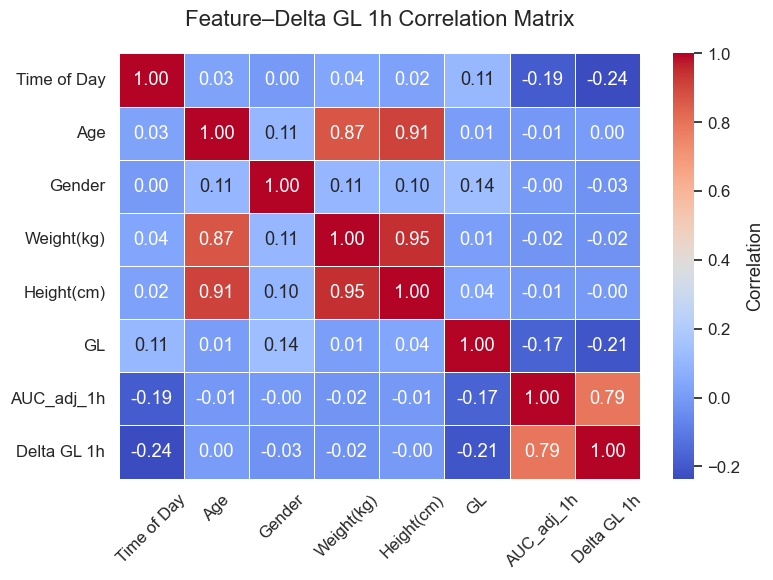

In [38]:
# 1시간 타겟 컬럼만 추가해서 상관관계 계산
corr_1h = df_event[feature_cols_1h + ['Delta GL 1h']].corr()

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.1)
sns.heatmap(
    corr_1h, 
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation'}
)
plt.title("Feature–Delta GL 1h Correlation Matrix", fontsize=16, pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [39]:
# xgboost 모델 저장
joblib.dump(xgb_model, "xgb_model.joblib")

# LightGBM 모델 저장
joblib.dump(lgb_model, "lgb_model.joblib")

['lgb_model.joblib']

# 실제 환아 데이터 적용()

In [40]:
def extract_event_features(df):
    result_rows = []

    # 파라미터(생리적 곡선 근거, 상황에 따라 조정 가능)
    rise_check_window_min = 20         # 식사 후 혈당상승을 확인할 시간(분)
    rise_check_window = rise_check_window_min // 15  # 데이터 간격이 5분 단위라고 가정
    pre_window_min = 30                # 식전 혈당평균 구간(분)
    rise_thresh = 15                   # 혈당상승폭 기준 (mg/dL)
    min_gap = timedelta(minutes=90)    # 이벤트 간 최소 간격

    # 사용자별 데이터 처리
    for user_id, user_df in df.groupby('ID'):
        user_df = user_df.sort_values('Timestamp').reset_index(drop=True)
        meal_events = []
        last_event_time = None

        # 인덱스 순회하며 식사 이벤트 예상
        for i in range(rise_check_window, len(user_df)):
            # 1) 식전 30분 평균 계산
            pre_start = max(i - (pre_window_min // 5), 0)
            pre_gl = user_df['GL'].iloc[pre_start:i].mean()

            # 2) 식후 20분 내 최대 혈당 찾기
            post_end = min(i + rise_check_window, len(user_df)-1)
            post_max = user_df['GL'].iloc[i:post_end+1].max()

            # 3) 상승폭 계산
            rise = post_max - pre_gl
            cur_time = user_df['Timestamp'].iloc[i]

            # 4) 혈당이 기준 이상 오르고, 이벤트 간 최소 간격을 넘겼다면 식사 이벤트로 추정
            if rise >= rise_thresh:
                if (last_event_time is None) or ((cur_time - last_event_time) >= min_gap):
                    meal_events.append(cur_time)
                    last_event_time = cur_time

        # 추정된 식사 이벤트별로 상세 정보 추출 (1시간 예측에 필요한 부분만)
        for meal_time in meal_events:
            # 5) 식전 30분 평균 (추정 이벤트 시각 기준)
            pre_mask = (user_df['Timestamp'] < meal_time) & \
                       (user_df['Timestamp'] >= meal_time - timedelta(minutes=pre_window_min))
            pre_gl = user_df.loc[pre_mask, 'GL'].mean()

            post_1h_start = meal_time + timedelta(minutes=40)
            post_1h_end = meal_time + timedelta(minutes=80)
            mask_1h = (user_df['Timestamp'] >= post_1h_start) & (user_df['Timestamp'] <= post_1h_end)
            if not user_df.loc[mask_1h].empty:
                post_1h_gl = user_df.loc[mask_1h, 'GL'].max()
            else:
                # 40~80분 구간에 값이 없다면, ±30분 내 가장 가까운 혈당값 사용
                target = meal_time + timedelta(minutes=60)
                window = 30  # ±30분
                mask_any = (user_df['Timestamp'] >= target - timedelta(minutes=window)) & \
                           (user_df['Timestamp'] <= target + timedelta(minutes=window))
                if not user_df.loc[mask_any].empty:
                    idx = (user_df.loc[mask_any, 'Timestamp'] - target).abs().idxmin()
                    post_1h_gl = user_df.loc[idx, 'GL']
                else:
                    post_1h_gl = np.nan

            # 7) 변화량 계산 (1시간 후만)
            delta_gl_1h = post_1h_gl - pre_gl if pd.notnull(pre_gl) and pd.notnull(post_1h_gl) else np.nan

            # 8) 결과 row 저장 (기본정보 + 1시간 파생변수)
            meal_idx = (user_df['Timestamp'] - meal_time).abs().idxmin()
            row = user_df.loc[meal_idx].to_dict()

            row['Meal_Event_Time'] = meal_time
            row['Pre GL'] = pre_gl
            row['Post1h GL'] = post_1h_gl
            row['Delta GL 1h'] = delta_gl_1h

            result_rows.append(row)
    return pd.DataFrame(result_rows)

def calc_auc(trace, time_col, glucose_col):
    if trace.empty or trace.shape[0] < 2:
        return np.nan
    time_min = (trace[time_col] - trace[time_col].min()).dt.total_seconds() / 60
    glucose = trace[glucose_col].values
    auc = np.trapz(glucose, time_min)
    return auc

def add_auc_features(df_event, base_df, interval_minutes_1h=60):
    aucs_1h = []
    for idx, row in df_event.iterrows():
        user_id = row['ID']
        meal_time = row['Meal_Event_Time']
        user_df = base_df[base_df['ID'] == user_id]

        start_1h = meal_time
        end_1h = meal_time + timedelta(minutes=interval_minutes_1h)
        mask_1h = (user_df['Timestamp'] >= start_1h) & (user_df['Timestamp'] <= end_1h)
        trace_1h = user_df.loc[mask_1h, ['Timestamp', 'GL']].copy()
        auc_1h = calc_auc(trace_1h, 'Timestamp', 'GL')
        aucs_1h.append(auc_1h)

    df_event['AUC_1h'] = aucs_1h
    df_event['AUC_adj_1h'] = df_event['AUC_1h'] - (df_event['Pre GL'] * interval_minutes_1h)
    return df_event


def predict_for_all(xgb_model, lgb_model, user_file_path):
    # 1. 전체 데이터 로드
    df = pd.read_csv(user_file_path)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

    # 2. 전체 데이터에서 이벤트/피처 추출
    df_event = extract_event_features(df)
    df_event = add_auc_features(df_event, df)

    # 3. Gender 변환
    if df_event['Gender'].dtype == 'object':
        df_event['Gender'] = df_event['Gender'].map({'M':1, 'F':0, '남':1, '여':0})
    df_event['Gender'] = df_event['Gender'].astype(float)

    # 4. feature만 남기고 결측치 제거
    feature_cols = [ 'Time of Day', 'Age', 'Gender', 'Weight(kg)', 'Height(cm)', 'GL', 'AUC_adj_1h' ]
    df_event = df_event.dropna(subset=feature_cols + ['Delta GL 1h'])
    X = df_event[feature_cols].astype(float)

    # 5. 두 모델로 예측
    xgb_pred = xgb_model.predict(X)
    lgb_pred = lgb_model.predict(X)
    pred = (xgb_pred + lgb_pred) / 2

    df_event['Predicted Delta GL 1h'] = pred

    return df_event[['ID', 'Timestamp', 'Delta GL 1h', 'Predicted Delta GL 1h']]

# 모델 불러오기
xgb_model = joblib.load("xgb_model.joblib")
lgb_model = joblib.load("lgb_model.joblib")

user_file = "actual_pediatric_patient_data.csv"
result_df = predict_for_all(xgb_model, lgb_model, user_file)


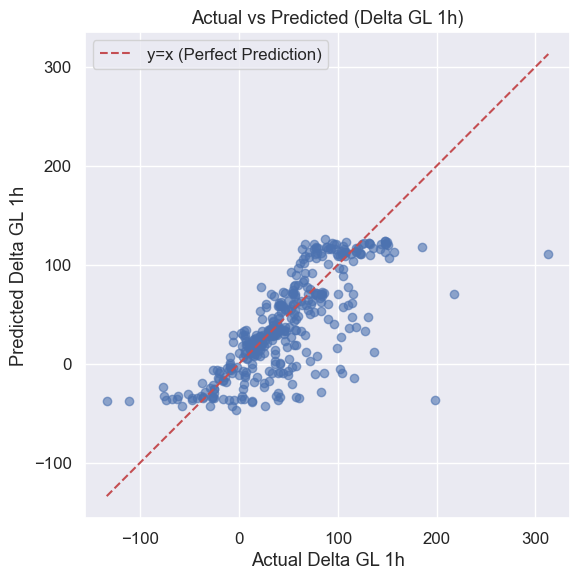

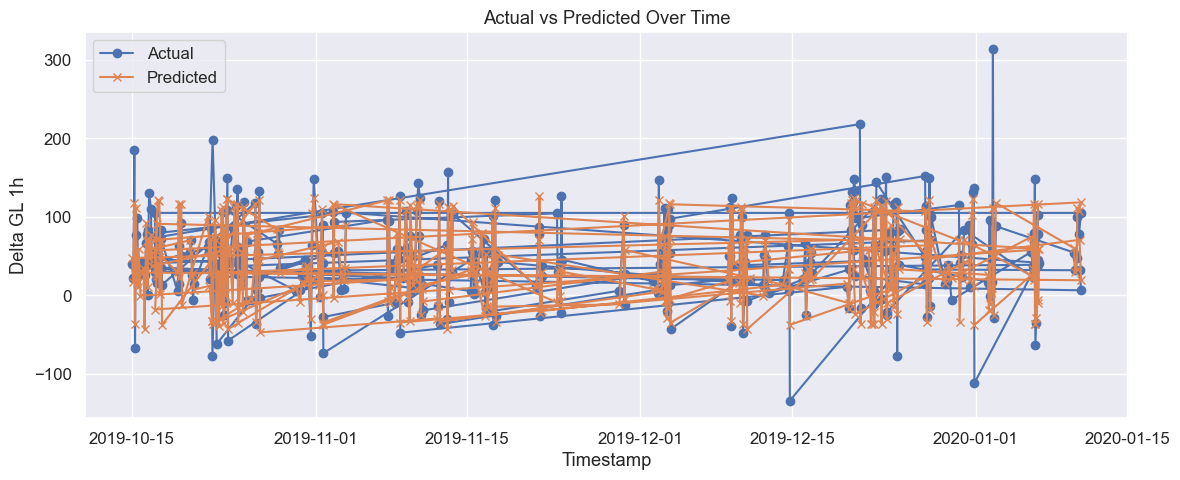

In [41]:
import matplotlib.pyplot as plt

# 산점도
plt.figure(figsize=(6, 6))
plt.scatter(result_df['Delta GL 1h'], result_df['Predicted Delta GL 1h'], alpha=0.6)
plt.plot([result_df['Delta GL 1h'].min(), result_df['Delta GL 1h'].max()],
         [result_df['Delta GL 1h'].min(), result_df['Delta GL 1h'].max()],
         'r--', label='y=x (Perfect Prediction)')
plt.xlabel('Actual Delta GL 1h')
plt.ylabel('Predicted Delta GL 1h')
plt.title('Actual vs Predicted (Delta GL 1h)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 시계열 선그래프
plt.figure(figsize=(12, 5))
plt.plot(result_df['Timestamp'], result_df['Delta GL 1h'], label='Actual', marker='o')
plt.plot(result_df['Timestamp'], result_df['Predicted Delta GL 1h'], label='Predicted', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Delta GL 1h')
plt.title('Actual vs Predicted Over Time')
plt.legend()
plt.tight_layout()
plt.show()
